# Slow Feature Analysis (SFA)
**Slow Feature Analysis (SFA)** とは, 複数の時系列データの中から低速に変化する成分 (slow feature) を抽出する教師なし学習のアルゴリズムである (Laurenz Wiskott, Berkes, Franzius, Sprekeler, & Wilbert, 2011; L. Wiskott & Sejnowski, 2002)．

潜在変数 $y$ の時間変化の2乗である $\left(\frac{dy}{dt}\right)^2$を最小にするように教師なし学習を行う．初期視覚野の受容野や格子細胞・場所細胞などのモデルに応用がされている (Franzius, Sprekeler, & Wiskott, 2007)．

生理学的妥当性についてはいくつかの検討がされている．(Sprekeler, Michaelis, & Wiskott, 2007)ではSTDP則によりSFAが実現できることを報告している．ただし，in vivoにおけるSTDPの存在については近年疑問視されている．これまでのin vitroでの実験は細胞外Ca濃度が高かったために、pre/postのスパイクの時間差でLTD/LTPが生じるという「古典的STDP則」が生じていた可能性があり，細胞外Ca濃度をin vivoの水準まで下げると古典的STDP則は起こらないという報告がある (Inglebert, Aljadeff, Brunel, & Debanne, 2020)．古典的な線形Recurrent neural networkでの実装も提案されている ([Lipshutz, Windolf, Golkar, & Chklovskii, 2020](https://arxiv.org/abs/2010.12644))．


In [1]:
using PyPlot, Statistics, LinearAlgebra

### SFAの前処理

SFAの前処理として多項式展開(polynomial expandsion)が用いられる ([Berkes & Wiskott, 2005](https://jov.arvojournals.org/article.aspx?articleid=2192836))．Pythonにおいては[sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)により使用できる．

In [2]:
monomials(n, d) = [t for t in Base.product(ntuple(i->0:d, Val{n}())...) if sum(t)<=d && sum(t) > 0]
polynomial_expand(X, d) =  hcat([[prod(X[i, :] .^ m) for m in monomials(size(X)[2], d)] for i in 1:size(X)[1]]...)'

whiten(X) = (X .- mean(X, dims=1)) ./ std(X, dims=1)

whiten (generic function with 1 method)

時間的にずらして時系列データの次元を増やす前処理も行われる．

In [3]:
time_frames(X, d) = hcat([X[i:end-d+i] for i in 1:d]...)

time_frames (generic function with 1 method)

### データセットの生成

In [4]:
# create the input signal
nt = 5000;
t = range(0, 2π, length=nt)

x1 = sin.(t) + 2*cos.(11*t).^2;
x2 = cos.(11*t);

X = [x1 x2];

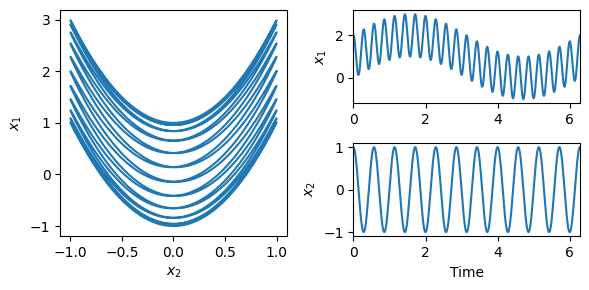

In [5]:
figure(figsize=(6, 3))
subplot2grid((2, 2), (0, 0), rowspan=2)
plot(x2, x1)
xlabel(L"$x_2$"); ylabel(L"$x_1$")
subplot2grid((2, 2), (0, 1))
plot(t, x1)
ylabel(L"$x_1$"); xlim(0, 2π)
subplot2grid((2, 2), (1, 1))
plot(t, x2)
xlabel("Time"); ylabel(L"$x_2$"); xlim(0, 2π)
tight_layout()

### SFAの実装

In [6]:
# Linear slow feature analysis
function linsfa(X)
    # X ∈ R^(dims x timesteps)
    Xw = whiten(X)
    _, _, V = svd(diff(Xw, dims=1))
    return Xw[1:end-1, :] * V; # V means weight matrix of X to Y
end

linsfa (generic function with 1 method)

### 実行と結果表示

In [7]:
Y = linsfa(polynomial_expand(X, 2));

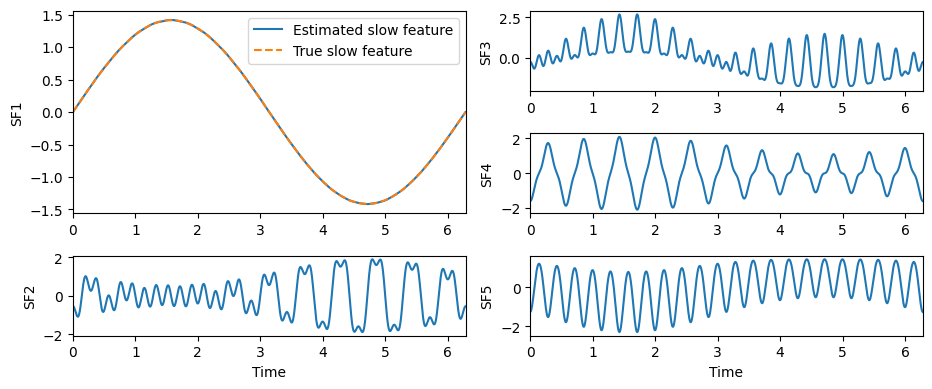

In [8]:
figure(figsize=(14, 4))
subplot2grid((3, 3), (0, 0), rowspan=2)
plot(t[1:end-1], whiten(Y[:, end]), label="Estimated slow feature")
plot(t[1:end-1], whiten(sin.(t[1:end-1])), "--", label="True slow feature")
ylabel("SF1"); xlim(0, 2π); legend(loc="upper right");
for i in 1:4
    if i == 1
        subplot2grid((3, 3), (2, 0))
        xlabel("Time");
    else
        subplot2grid((3, 3), (i-2, 1))
    end
    plot(t[1:end-1], whiten(Y[:, end-i]))
    ylabel("SF"*string(i+1)); xlim(0, 2π)
end
xlabel("Time")
tight_layout()

### 参考文献
- <https://towardsdatascience.com/a-brief-introduction-to-slow-feature-analysis-18c901bc2a58>
- <https://github.com/flatironinstitute/bio-sfa>
- <https://github.com/fulviadelduca/slow-feature-analysis>
- [Deep Slow Feature Analysis Network](https://github.com/rulixiang/DSFANet)
- <https://nbviewer.jupyter.org/github/pierrelux/notebooks/blob/master/Slow%20Feature%20Analysis.ipynb>